In [1]:
############# DATA EXPLORATION AND PROCESSING ##########################
edvoldata = read.csv("EGDailyVolume.csv",header=T)
## Process Dates 
year = edvoldata$Year
month = edvoldata$Month
day = edvoldata$Day
datemat = cbind(as.character(day),as.character(month),as.character(year))

In [2]:
head(datemat)

1,1,2010
2,1,2010
3,1,2010
4,1,2010
5,1,2010
6,1,2010


In [3]:
paste.dates = function(date){
    day = date[1]; month=date[2]; year = date[3]
    return(paste(day,month,year,sep="/"))
 }
dates = apply(datemat,1,paste.dates)
dates = as.Date(dates, format="%d/%m/%Y")
edvoldata = cbind(dates,edvoldata)
attach(edvoldata)

The following object is masked _by_ .GlobalEnv:

    dates



In [4]:
head(edvoldata)

dates,Year,Month,Day,Volume
2010-01-01,2010,1,1,135
2010-01-02,2010,1,2,163
2010-01-03,2010,1,3,139
2010-01-04,2010,1,4,139
2010-01-05,2010,1,5,122
2010-01-06,2010,1,6,119


Warning message:
"package 'ggplot2' was built under R version 3.6.3"

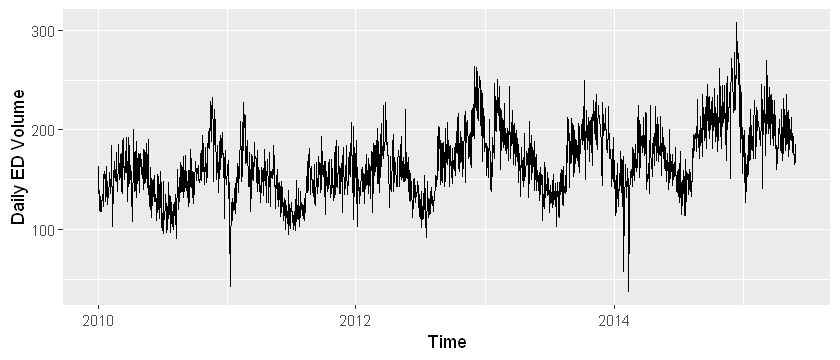

In [5]:
library(ggplot2)
options(repr.plot.width=7, repr.plot.height=3)
ggplot(edvoldata, aes(dates, Volume)) + geom_line() + xlab("Time") + ylab("Daily ED Volume")

<li> Increasing trend
 <li> Some cyclicity (not seasonality)
     <li> Some outliers
         

### Differencing to make stationary

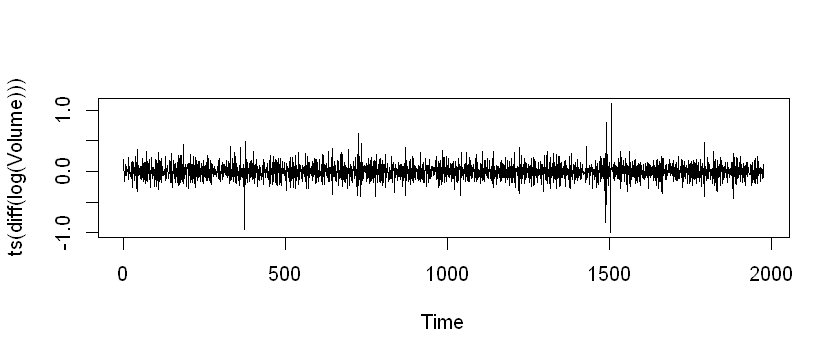

In [6]:
plot(ts(diff(log(Volume))))

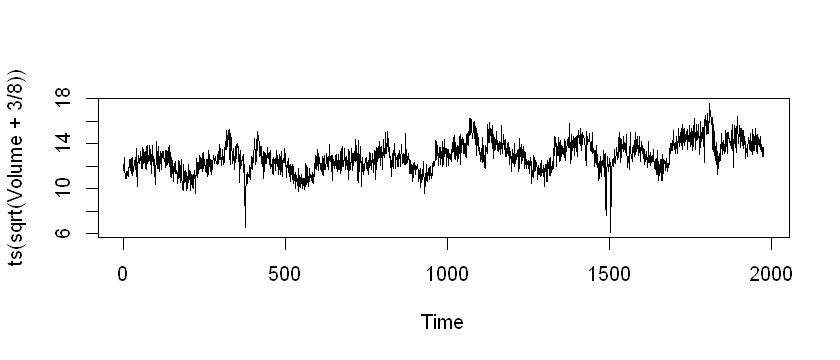

In [7]:
plot(ts(sqrt(Volume+3/8)))

We take here the second differencing (it has same series but with less variability)

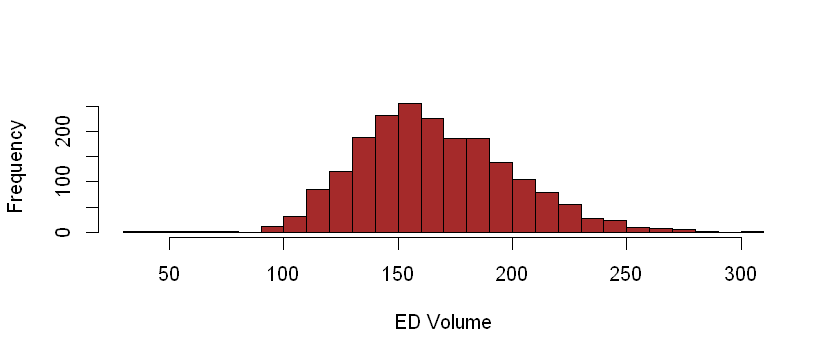

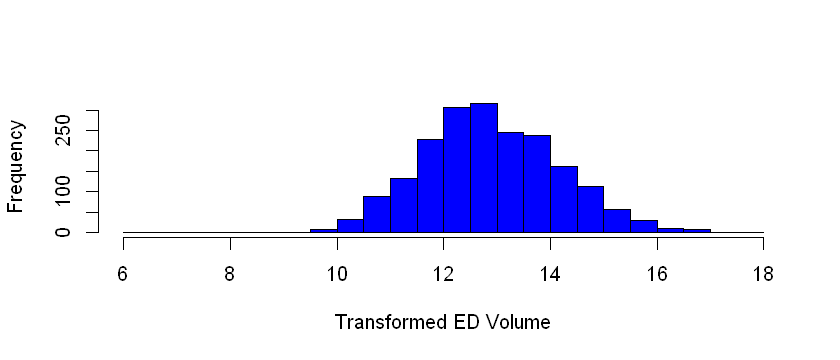

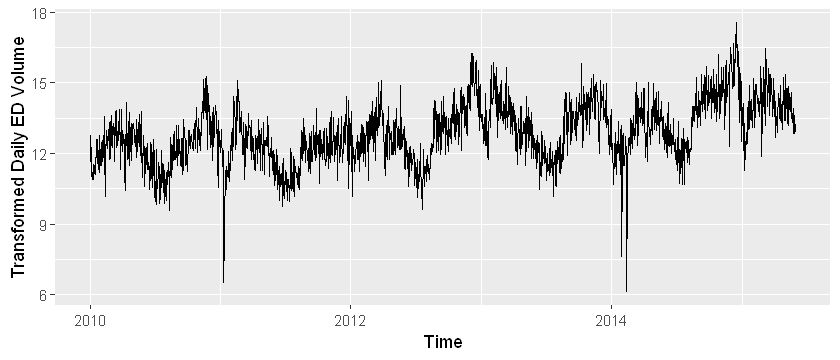

In [8]:
Volume.tr = sqrt(Volume+3/8)
Volume.tr.ts= ts(Volume.tr)
hist(Volume,nclass=20,xlab="ED Volume", main="",col="brown")
hist(Volume.tr,nclass=20,xlab= "Transformed ED Volume", main="",col="blue")
ggplot(edvoldata, aes(dates, sqrt(Volume+3/8))) + geom_line() + xlab("Time") + ylab("Transformed Daily ED Volume")

## Trend estimation

Here only used non parametric regression:

Warning message:
"package 'mgcv' was built under R version 3.6.3"Loading required package: nlme
Warning message:
"package 'nlme' was built under R version 3.6.3"This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



Family: gaussian 
Link function: identity 

Formula:
Volume.tr ~ s(time.pts)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.85769    0.02441   526.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 8.628   8.96 93.39  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.296   Deviance explained = 29.9%
GCV =  1.184  Scale est. = 1.1782    n = 1977

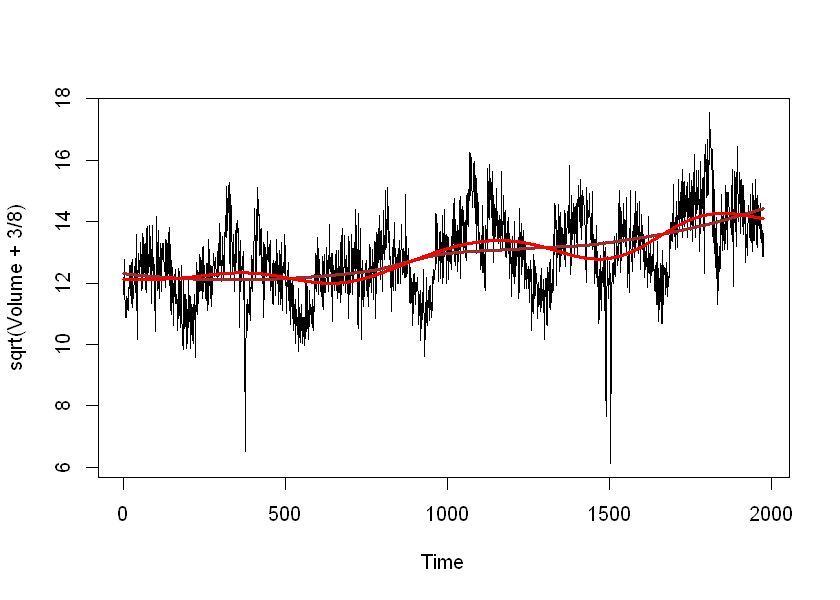

In [9]:
################ TREND AND SEASONALITY ESTIMATION #########################
library(mgcv)

time.pts = c(1:length(Volume))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

## Trend Estimation: Is there a trend?

## Local Polynomial Trend Estimation
loc.fit = loess(Volume.tr~time.pts)
#summary(loc.fit)
vol.fit.loc = fitted(loc.fit)

## Splines Trend Estimation
gam.fit = gam(Volume.tr~s(time.pts))
summary(gam.fit)
vol.fit.gam = fitted(gam.fit)

## Is there a trend? 
options(repr.plot.width=7, repr.plot.height=5)

plot.ts(sqrt(Volume+3/8))
    
lines(vol.fit.loc,lwd=3,col="brown")
lines(vol.fit.gam,lwd=3,col="red")

We see there is significant p value for splines GAM (see the smooth term's p value not for intercept) indicating significant trend.

## Model Trend + Monthly Seasonality


In [10]:
## Using nonparametric trend and linear regression seasonality 
month = as.factor(format(dates,"%b"))
month[1:37]

[1] Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan
[20] Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Jan Feb Feb Feb Feb Feb Feb
Levels: Apr Aug Dec Feb Jan Jul Jun Mar May Nov Oct Sep


Family: gaussian 
Link function: identity 

Formula:
Volume.tr ~ s(time.pts) + month

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.86352    0.06200 207.472  < 2e-16 ***
monthAug    -0.50070    0.09192  -5.447 5.76e-08 ***
monthDec     0.93644    0.09128  10.259  < 2e-16 ***
monthFeb     0.33487    0.08835   3.790 0.000155 ***
monthJan    -0.59912    0.08685  -6.898 7.09e-12 ***
monthJul    -1.53494    0.09170 -16.739  < 2e-16 ***
monthJun    -1.00621    0.09220 -10.913  < 2e-16 ***
monthMar     0.62121    0.08590   7.232 6.81e-13 ***
monthMay     0.05152    0.08589   0.600 0.548708    
monthNov     0.94133    0.09242  10.186  < 2e-16 ***
monthOct     0.41487    0.09189   4.515 6.71e-06 ***
monthSep     0.22663    0.09277   2.443 0.014657 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 8.777  8.985 140.7  <2e-16 ***
---

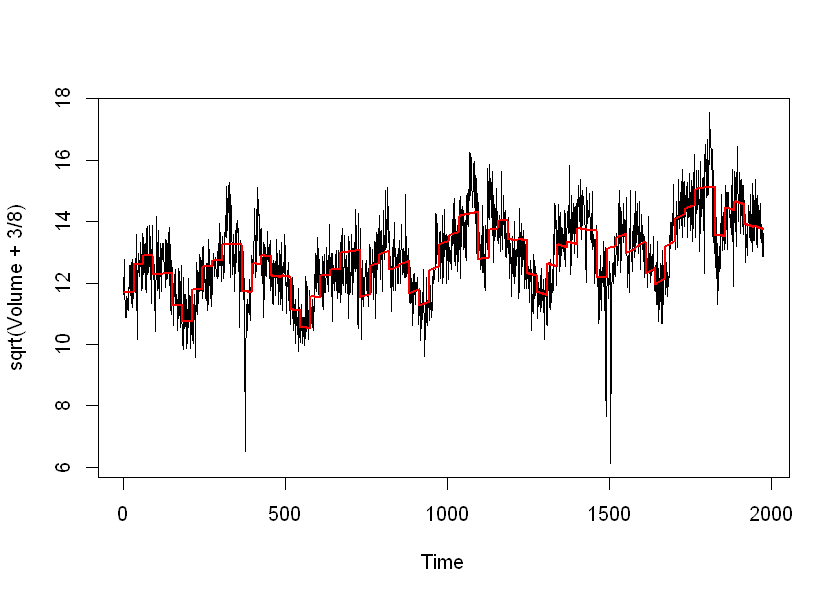

In [11]:
#s(time.pts) means they can be complexed like time.pts, time.pts^2 etc... 
#while month will be treated as a simple linear variable
gam.fit.seastr.1 = gam(Volume.tr~s(time.pts)+month)

summary(gam.fit.seastr.1)
vol.fit.gam.seastr.1 = fitted(gam.fit.seastr.1)

plot.ts(sqrt(Volume+3/8))
lines(vol.fit.gam.seastr.1,lwd=2,col="red")

We see step like function in the fitted(trained model) curve as the months have different parameters estimated and each step indicates a month transition. ER visits may vary more in certain months (ex school going months etc). We also fit a model for the days of the week inference.


Family: gaussian 
Link function: identity 

Formula:
Volume.tr ~ s(time.pts) + month + week

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   12.77772    0.07383 173.063  < 2e-16 ***
monthAug      -0.50061    0.08852  -5.655 1.79e-08 ***
monthDec       0.93273    0.08791  10.611  < 2e-16 ***
monthFeb       0.33589    0.08509   3.948 8.17e-05 ***
monthJan      -0.59767    0.08365  -7.145 1.26e-12 ***
monthJul      -1.53530    0.08831 -17.385  < 2e-16 ***
monthJun      -1.00553    0.08880 -11.324  < 2e-16 ***
monthMar       0.61815    0.08272   7.472 1.18e-13 ***
monthMay       0.05271    0.08272   0.637  0.52403    
monthNov       0.94163    0.08900  10.580  < 2e-16 ***
monthOct       0.41557    0.08849   4.696 2.84e-06 ***
monthSep       0.22391    0.08935   2.506  0.01229 *  
weekMonday     0.57169    0.06647   8.601  < 2e-16 ***
weekSaturday   0.04589    0.06641   0.691  0.48967    
weekSunday     0.17538    0.06641   2.641  0.00834 ** 
w

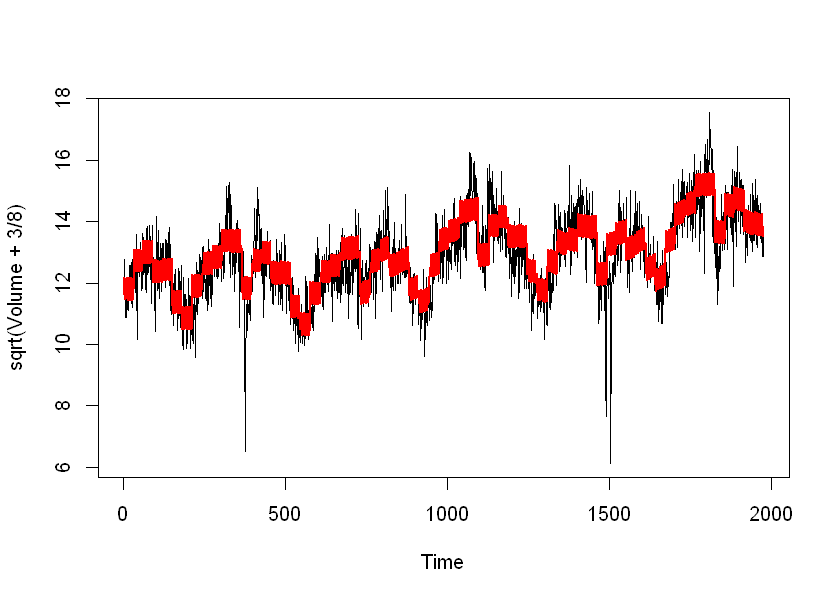

In [12]:
## Add day-of-the-week seasonality
week = as.factor(weekdays(dates))
gam.fit.seastr.2 = gam(Volume.tr~s(time.pts)+month+week)
summary(gam.fit.seastr.2)

vol.fit.gam.seastr.2 = fitted(gam.fit.seastr.2)

plot.ts(sqrt(Volume+3/8))
lines(vol.fit.gam.seastr.2,lwd=2,col="red")

Zoomed in comparison of :

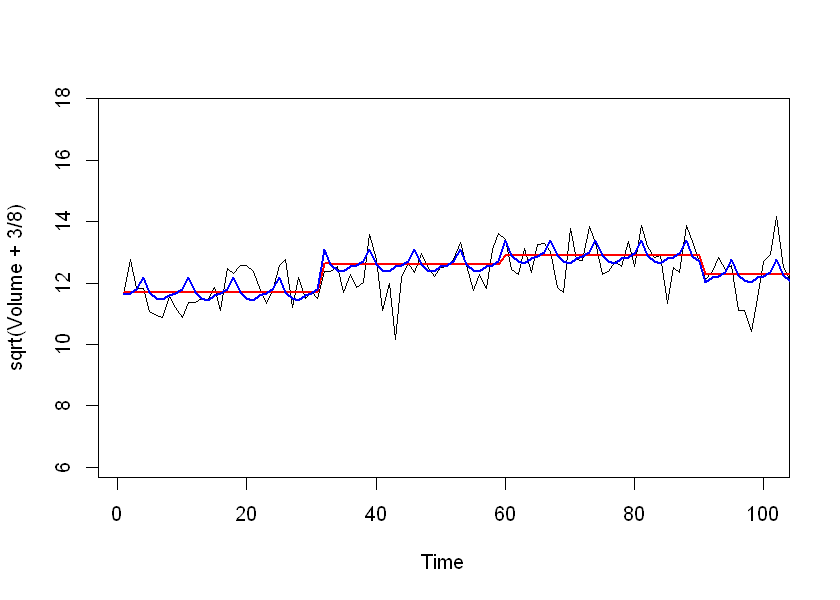

In [13]:
plot.ts(sqrt(Volume+3/8), xlim=c(1,100))
lines(vol.fit.gam.seastr.1,lwd=2,col="red")
lines(vol.fit.gam.seastr.2,lwd=2,col="blue")

Some day seasonality coefficients are significant. Also, We see there is significant p value for splines GAM (see the smooth term's p value, not for intercept) indicating significant trend.

## Comparing if significant difference between models using ANOVA:

Note ANOVA can work upon 2 fitted similar lm models for <b> month </b> only and <b> month+week </b> as samples and tell us if they come from same population or not. (ie tell if the models are same or not statistically)

In [14]:
## Does the addition of seasonality of day of the week adds predictive power? NOTE: trend is not included here
lm.fit.seastr.1 = lm(Volume.tr~month)
lm.fit.seastr.2 = lm(Volume.tr~month+week)
anova(lm.fit.seastr.1,lm.fit.seastr.2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
1965,2169.875,NA,NA,NA,NA
1959,2071.048,6,98.82605,15.57989,1.543093e-17


Models have significant mean difference. Hence the month + week model's explanatory power is not by chance and is truly explaining more variance.

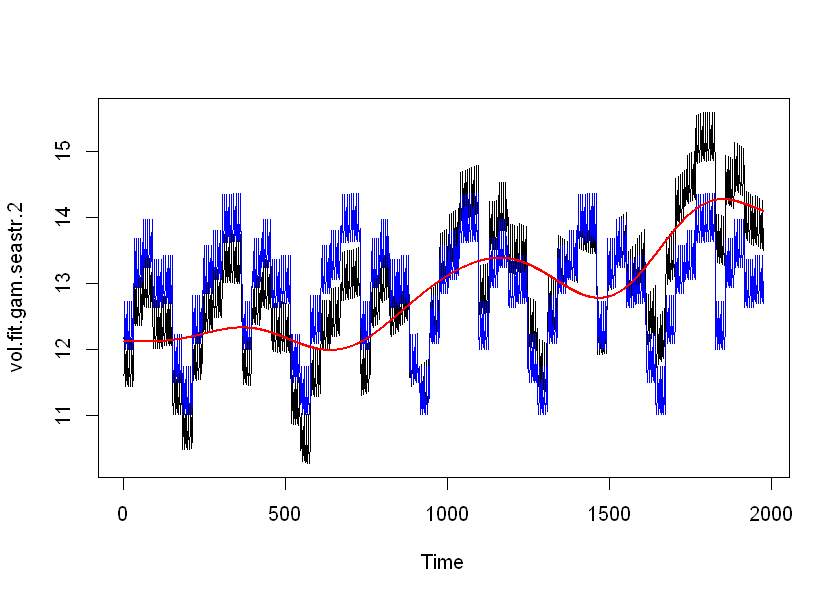

In [15]:
vol.fit.lm.seastr.2 = fitted(lm.fit.seastr.2)
#week+month+trend
plot.ts(vol.fit.gam.seastr.2)
#only week+month season
lines(vol.fit.lm.seastr.2,lwd=1,col="blue")
#only trend
lines(vol.fit.gam,lwd=2,col="red")

## Residual analysis

In [24]:
################## STATIONARITY: RESIDUAL PROCESS ####################
## Residual Process: Only Trend Removal
resid.1 = Volume.tr-vol.fit.gam
## Residual Process: Only Seasonality Removal
resid.2 = Volume.tr-vol.fit.lm.seastr.2
## Residual Process: Trend & Seasonality Removal
resid.3 = Volume.tr-vol.fit.gam.seastr.2
y.min = min(c(resid.1,resid.2,resid.3))
y.max = max(c(resid.1,resid.2,resid.3))

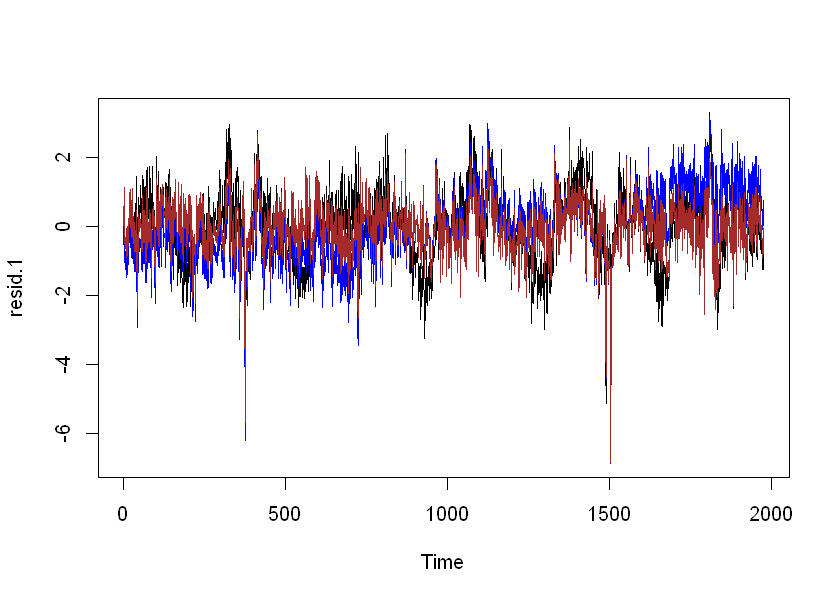

In [25]:
plot.ts(resid.1, ylim=c(y.min,y.max))
lines(resid.2,col="blue")
lines(resid.3,col="brown")

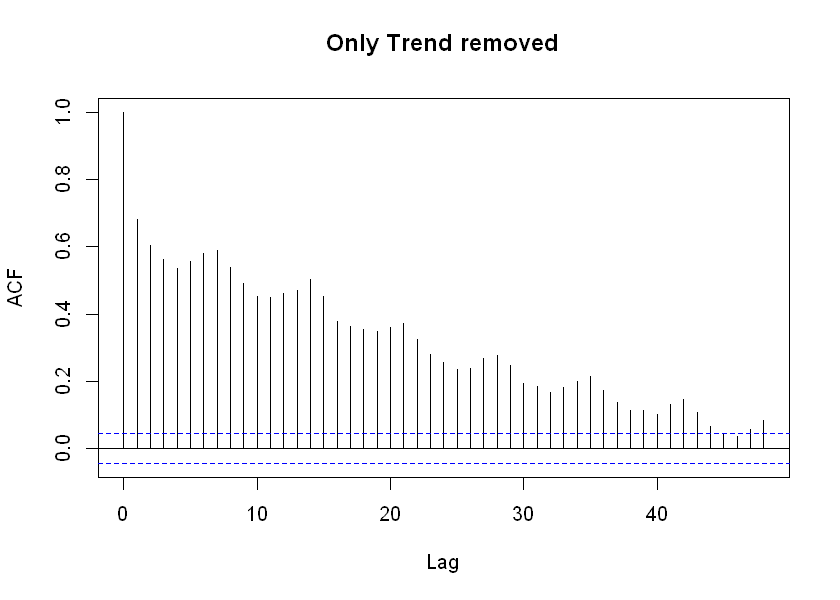

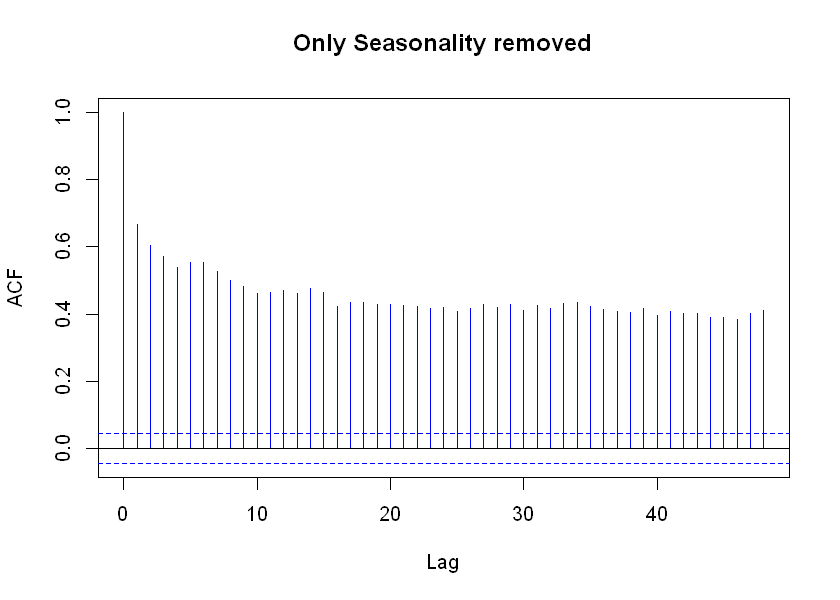

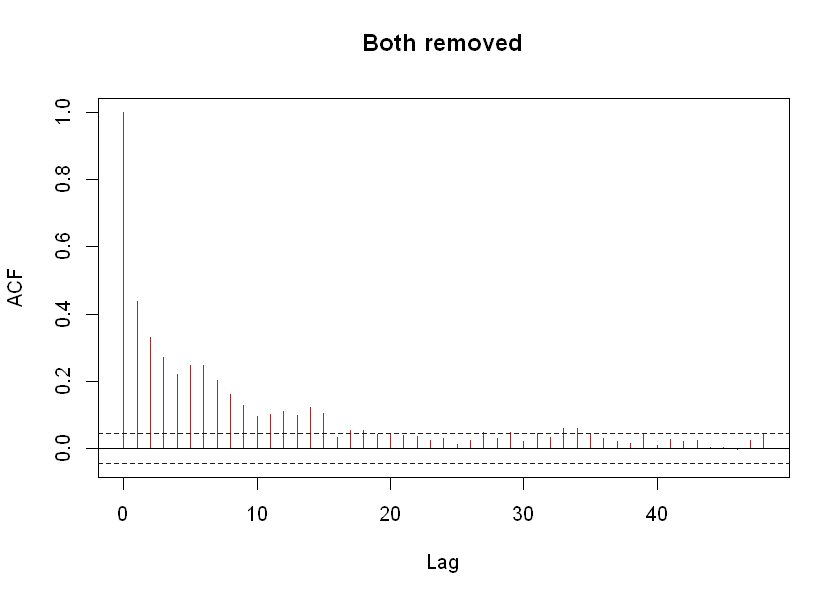

In [26]:
acf(resid.1,lag.max=12*4,main="Only Trend removed")
acf(resid.2,lag.max=12*4,main="Only Seasonality removed",col="blue")
acf(resid.3,lag.max=12*4,main="Both removed",col="brown")

Last residual series(detrended series using both week+months) looks stationary from fast decaying ACF plot as compared to other two. We can apply ARMA on it.